<a href="https://colab.research.google.com/github/jansoe/dl_workshop/blob/main/Adverserial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adverserial Attacks

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

## Pretrained model

See for available models https://keras.io/api/applications/

In [ ]:
from tensorflow.keras.applications import mobilenet_v2

model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


Let's download some image

In [ ]:
!wget -O example.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Grand_Ducal_Police_car_%28Ford%29_in_Luxembourg_City.jpg/320px-Grand_Ducal_Police_car_%28Ford%29_in_Luxembourg_City.jpg

--2021-01-02 13:56:55--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Grand_Ducal_Police_car_%28Ford%29_in_Luxembourg_City.jpg/320px-Grand_Ducal_Police_car_%28Ford%29_in_Luxembourg_City.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19547 (19K) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>]  19.09K  --.-KB/s    in 0.02s   

2021-01-02 13:56:55 (963 KB/s) - ‘example.jpg’ saved [19547/19547]



Apply the same data preprocessing as used in Training

In [ ]:
img = tf.keras.preprocessing.image.load_img('./example.jpg', target_size=(224,224))

img_pp = mobilenet_v2.preprocess_input(tf.keras.preprocessing.image.img_to_array(img))
img_pp = img_pp[None, ...]

img_pp.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


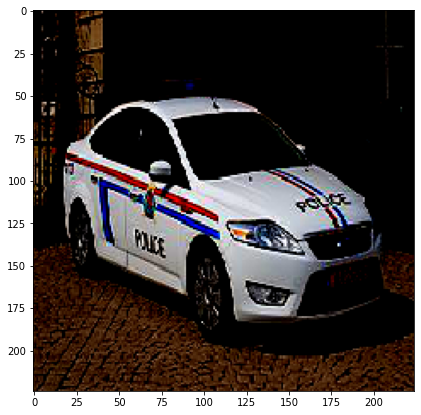

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.imshow(img_pp.squeeze())

Get the prediction

In [ ]:
prediction = model.predict(img_pp)
mobilenet_v2.decode_predictions(prediction, top=3)

40960/35363 [==================================] - 0s 0us/step


[[('n03977966', 'police_van', 0.7280083),
  ('n04037443', 'racer', 0.05290055),
  ('n02701002', 'ambulance', 0.038208142)]]

### Adverserial Attack

We will define a function to calculate the gradient of the loss with respect ot the input 

In [ ]:
def get_gradient_direction(model, model_input, label):

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    with tf.GradientTape() as tape:
        model_output = model(model_input)
        loss = loss_function(label, model_output)

    # Get the gradients of the loss w.r.t to the input image (dL/dx).
    gradient = tape.gradient(loss, model_input)
    
    # Get the sign of the gradients to create the perturbation
    gradient_direction = tf.sign(gradient)

    return gradient_direction

and calculate the direction in which the loss will increase most

In [ ]:
label_id = 734 #police_van_index (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

x = tf.Variable(
    initial_value = img_pp,
    trainable=True
)

gradient_direction = get_gradient_direction(model, x, label_id)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


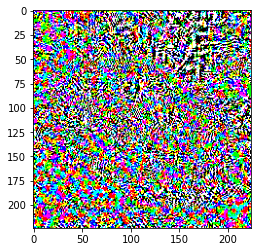

In [ ]:
plt.imshow(gradient_direction.numpy().squeeze())

If we change our input in this direction, we will make it less likely to have the correct label

In [ ]:
adversarial_img = (img_pp + 0.005 *gradient_direction.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


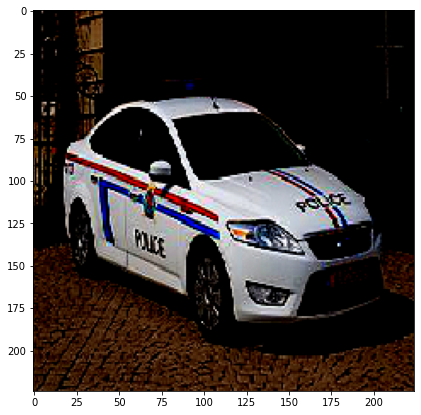

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.imshow(adversarial_img.squeeze())

So even if there is little change to the human eye ... 

In [ ]:
prediction = model.predict(adversarial_img)
mobilenet_v2.decode_predictions(prediction, top=3)

[[('n04037443', 'racer', 0.38918504),
  ('n04285008', 'sports_car', 0.1715128),
  ('n03895866', 'passenger_car', 0.06582139)]]

... the output of the network is changed 